In [29]:
import argparse
import torch
import wandb

from my_dassl.utils import setup_logger, set_random_seed, collect_env_info
from my_dassl.config import get_cfg_default
from my_dassl.engine import build_trainer

import datasets.oxford_pets
import datasets.oxford_flowers
import datasets.fgvc_aircraft
import datasets.dtd
import datasets.eurosat
import datasets.stanford_cars
import datasets.food101
import datasets.sun397
import datasets.caltech101
import datasets.ucf101
import datasets.imagenet
import datasets.svhn
import datasets.resisc45
import datasets.clevr

import datasets.locmnist
import datasets.colour_biased_mnist

import trainers.coop
import trainers.cocoop
import trainers.zsclip
import trainers.ftclip
import trainers.vpwb
import trainers.vpour
# import trainers.blackvip
import trainers.blackvip_t2t
# import trainers.blackvip_jh
import trainers.reprogramming

import pdb

PATCH_NUM = 0
DATA = './datasets'
TRAINER = 'BLACKVIP'
SHOTS = 16
CFG = 'vit_b16'
ptb = 'vit-mae-base'

DATASET = 'eurosat'
ep = 5000

spsa_os = 1.0
alpha = 0.4
spsa_a = 0.01

b1 = float(0.9)
gamma = float(0.2)
spsa_c = float(0.005)
p_eps = float(0.4)

opt_type = 'spsa-gc'


In [30]:
def extend_cfg(cfg):
    """
    Add new config variables.

    E.g.
        from yacs.config import CfgNode as CN
        cfg.TRAINER.MY_MODEL = CN()
        cfg.TRAINER.MY_MODEL.PARAM_A = 1.
        cfg.TRAINER.MY_MODEL.PARAM_B = 0.5
        cfg.TRAINER.MY_MODEL.PARAM_C = False
    """
    from yacs.config import CfgNode as CN

    # ! DATASET CONFIG
    cfg.DATASET.SUBSAMPLE_CLASSES = "all"  # all, base or new

    cfg.DATASET.LOCMNIST = CN()
    cfg.DATASET.LOCMNIST.R_SIZE = 1
    cfg.DATASET.LOCMNIST.F_SIZE = 4

    cfg.DATASET.COLOUR_BIASED_MNIST = CN()
    cfg.DATASET.COLOUR_BIASED_MNIST.TRAIN_RHO = 0.8
    cfg.DATASET.COLOUR_BIASED_MNIST.TEST_RHO = 0.2
    cfg.DATASET.COLOUR_BIASED_MNIST.TRAIN_N_CONFUSING_LABELS = 9
    cfg.DATASET.COLOUR_BIASED_MNIST.TEST_N_CONFUSING_LABELS = 9
    cfg.DATASET.COLOUR_BIASED_MNIST.USE_TEST_AS_VAL = True
    cfg.DATASET.COLOUR_BIASED_MNIST.RANDOMIZE = True if args.randomize else False

    # ! Bahng et al. Visual Prompting (VP)
    cfg.TRAINER.VPWB = CN()
    cfg.TRAINER.VPWB.PREC = "amp"  # fp16, fp32, amp
    cfg.TRAINER.VPWB.METHOD = 'padding'  # 'padding', 'fixed_patch', 'random_patch'
    cfg.TRAINER.VPWB.IMAGE_SIZE = 224
    cfg.TRAINER.VPWB.PROMPT_SIZE = 30

    # ! Visual Prompting (VP) with SPSA
    cfg.TRAINER.VPOUR = CN()
    cfg.TRAINER.VPOUR.METHOD = 'padding'
    cfg.TRAINER.VPOUR.IMAGE_SIZE = 224
    cfg.TRAINER.VPOUR.PROMPT_SIZE = 30
    cfg.TRAINER.VPOUR.SPSA_PARAMS = [0.0, 0.001, 40.0, 0.6, 0.1]
    cfg.TRAINER.VPOUR.OPT_TYPE = "spsa-gc"
    cfg.TRAINER.VPOUR.MOMS = 0.9
    cfg.TRAINER.VPOUR.SP_AVG = 5

    # ! BlackVIP
    cfg.TRAINER.BLACKVIP = CN()
    cfg.TRAINER.BLACKVIP.METHOD = 'coordinator'
    cfg.TRAINER.BLACKVIP.PT_BACKBONE = ptb  # vit-base / vit-mae-base
    cfg.TRAINER.BLACKVIP.SRC_DIM = 1568  # 784 / 1568 / 3136 #? => only for pre-trained Enc
    cfg.TRAINER.BLACKVIP.E_OUT_DIM = 0  # 64 / 128 / 256 #? => only for scratch Enc
    cfg.TRAINER.BLACKVIP.SPSA_PARAMS = [1.0, 0.005, 0.01, 0.4, 0.2]
    cfg.TRAINER.BLACKVIP.OPT_TYPE = "spsa-gc"  # [spsa, spsa-gc, naive]
    cfg.TRAINER.BLACKVIP.MOMS = b1  # first moment scale.
    cfg.TRAINER.BLACKVIP.SP_AVG = 5  # grad estimates averaging steps
    cfg.TRAINER.BLACKVIP.P_EPS = p_eps  # prompt scale
    cfg.TRAINER.BLACKVIP.smoothing = False
    # ! Black-Box Adversarial Reprogramming (BAR)
    cfg.TRAINER.BAR = CN()
    cfg.TRAINER.BAR.METHOD = 'reprogramming'
    cfg.TRAINER.BAR.LRS = [0.01, 0.0001]
    cfg.TRAINER.BAR.FRAME_SIZE = 224
    cfg.TRAINER.BAR.SMOOTH = 0.01
    cfg.TRAINER.BAR.SIMGA = 1.0
    cfg.TRAINER.BAR.SP_AVG = 5
    cfg.TRAINER.BAR.FOCAL_G = 2.0

    # ! Full Fine Tune / Linear Probe
    cfg.TRAINER.FTCLIP = CN()
    cfg.TRAINER.FTCLIP.METHOD = 'ft'  # 'ft', 'lp'

    # ! CoOp, CoCoOp
    cfg.TRAINER.COOP = CN()
    cfg.TRAINER.COOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COOP.CSC = False  # class-specific context
    cfg.TRAINER.COOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COOP.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.COOP.CLASS_TOKEN_POSITION = "end"  # 'middle' or 'end' or 'front'

    #
    cfg.OPTIM.MAX_EPOCH = 500
    cfg.DATASET.NUM_SHOTS = 16
    cfg.TRAIN.CHECKPOINT_FREQ = 500
    cfg.TRAINER.BLACKVIP.P_EPS_number = PATCH_NUM

    cfg.TRAINER.COCOOP = CN()
    cfg.TRAINER.COCOOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COCOOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COCOOP.PREC = "fp16"  # fp16, fp32, amp
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.eval_only:
        cfg.eval_only = 1
    else:
        cfg.eval_only = 0

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.wb_method_name != 'no':
        cfg.WB_METHOD_NAME = args.wb_method_name

    if args.use_wandb:
        cfg.use_wandb = 1
    else:
        cfg.use_wandb = 0

    cfg.EVAL_MODE = 'best'

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head
    if args.patch_size:
        cfg.TRAINER.PATCH = args.patch_size

In [31]:
def setup_cfg(args):
    cfg = get_cfg_default()
    extend_cfg(cfg)

    # 1. From the dataset config file
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)

    # 2. From the method config file
    if args.config_file:
        cfg.merge_from_file(args.config_file)

    # 3. From input arguments
    reset_cfg(cfg, args)

    # 4. From optional input arguments
    # print(args.opts)
    # cfg.merge_from_list(args.opts)

    cfg.freeze()
    return cfg
    
import argparse

# Manually creating a Namespace object to simulate command-line arguments
args = argparse.Namespace(
    root='./datasets',
    # output_dir=f'output/eurosat/BLACKVIP/vit-mae-base_vit_b16/shot16_ep5000_orignal/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1',
    # output_dir = f'output/eurosat/BLACKVIP/vit-mae-base_vit_b16/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4_jh/seed1',
    # output_dir = f'output/eurosat/BLACKVIP/vit-mae-base_vit_b16_nt/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1',
    output_dir = f'output/eurosat/BLACKVIP_right_t2t/vit-mae-base_vit_b16_t2t/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1',
    # output_dir=f'output/colour_biased_mnist_easy/BLACKVIP/vit-mae-base_vit_b16_noaug/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.1_sa0.01_sc0.01_eps1.0/seed1',
    resume='',
    seed=1,
    source_domains=None,  # Update this as needed
    target_domains=None,  # Update this as needed
    transforms=None,  # Update this as needed
    config_file='configs/trainers/BLACKVIP/vit_b16_t2t.yaml',
    dataset_config_file='configs/datasets/eurosat.yaml',
    trainer='BLACKVIP',
    backbone='',  # Update this as needed
    head='',  # Update this as needed
    eval_only=False,
    model_dir='',  # Update this as needed
    load_epoch=None,  # Update this as needed
    no_train=False,
    use_wandb=False,
    wb_name='test',
    wb_method_name='no',
    randomize=1,
    patch_size = 16

    # opts=None  # Update this as needed, if you need to pass any additional command line arguments
)
def print_args(args, cfg):
    print("***************")
    print("** Arguments **")
    print("***************")
    optkeys = list(args.__dict__.keys())
    optkeys.sort()
    for key in optkeys:
        print("{}: {}".format(key, args.__dict__[key]))
    print("************")
    print("** Config **")
    print("************")
    print(cfg)
    
cfg = setup_cfg(args)
if cfg.SEED >= 0:
    print("Setting fixed seed: {}".format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = True

print_args(args, cfg)
print("Collecting env info ...")

try:
    print("** System info **\n{}\n".format(collect_env_info()))  #
except:
    pass

baseacc, newacc, all_best_acc = 0, 0, 0

from my_dassl.data.transforms import INTERPOLATION_MODES, build_transform
import torchvision.transforms as T
interp_mode = INTERPOLATION_MODES[cfg.INPUT.INTERPOLATION]
to_tensor = []
to_tensor += [T.Resize(cfg.INPUT.SIZE, interpolation=interp_mode)]
to_tensor += [T.ToTensor()]
if "normalize" in cfg.INPUT.TRANSFORMS:
    normalize = T.Normalize(
        mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD
    )
    to_tensor += [normalize]
tensor_tr = T.Compose(to_tensor)

In [32]:
stop

NameError: name 'stop' is not defined

In [33]:
trainer = build_trainer(cfg)
print(trainer.output_dir, args.load_epoch)
args.load_epoch
trainer.load_model(trainer.output_dir, epoch=5000)
dtype = trainer.model.dtype

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing PromptViTForImageClassification: ['decoder.decoder_layers.5.attention.attention.value.bias', 'decoder.decoder_layers.3.layernorm_before.weight', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.2.attention.attention.query.bias', 'decoder.decoder_layers.1.attention.attention.value.weight', 'decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.6.intermediate.dense.bias', 'decoder.decoder_layers.0.attention.output.dense.bias', 'decoder.decoder_layers.5.layernorm_before.bias', 'decoder.decoder_layers.1.attention.output.dense.weight', 'decoder.decoder_layers.1.output.dense.bias', 'decoder.decoder_layers.4.intermediate.dense.weight', 'decoder.decod

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define function to extract patches and calculate norms
def extract_patches_and_calculate_norms(tensor, patch_size=4, threshold=150, check=False):
    patches = tensor.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(1, 3, -1, patch_size, patch_size)
    patches = patches.permute(2, 0, 1, 3, 4).reshape(-1, 3, patch_size, patch_size)
    norm_img = torch.norm(patches, p=2, dim=(1, 2, 3))
    indices_under_t = norm_img < threshold
    norms_under_t = norm_img[indices_under_t]
    if check:
        return norms_under_t, indices_under_t, norm_img
    return norms_under_t, indices_under_t

# Function to plot norms under threshold
def plot_norms_under_threshold(ax, norms, indices, title, patch_size=4):
    norms_image = torch.full((224 // patch_size, 224 // patch_size), float('nan'))
    norms_image[indices.view(224 // patch_size, 224 // patch_size)] = norms
    cax = ax.imshow(norms_image.numpy(), cmap='viridis')
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)

In [41]:
from glob import glob
from PIL import Image
trainer.set_model_mode("eval")
trainer.evaluator.reset()
for ii,i in enumerate(glob('datasets/eurosat/2750/River/*.jpg')):
    ori_img = Image.open(i).convert("RGB")
    img = tensor_tr(ori_img)
    img = img.unsqueeze(0) 
    prompt, z = trainer.model.coordinator(img.cuda().type(dtype))
    if ii == 20:
        break

In [23]:
from torchvision import transforms
transform = transforms.Compose([transforms.Resize((224, 224))])
resized_img_pil = transform(ori_img)
resized_img_tensor = transforms.ToTensor()(resized_img_pil)
resized_img_tensor = resized_img_tensor.unsqueeze(0)

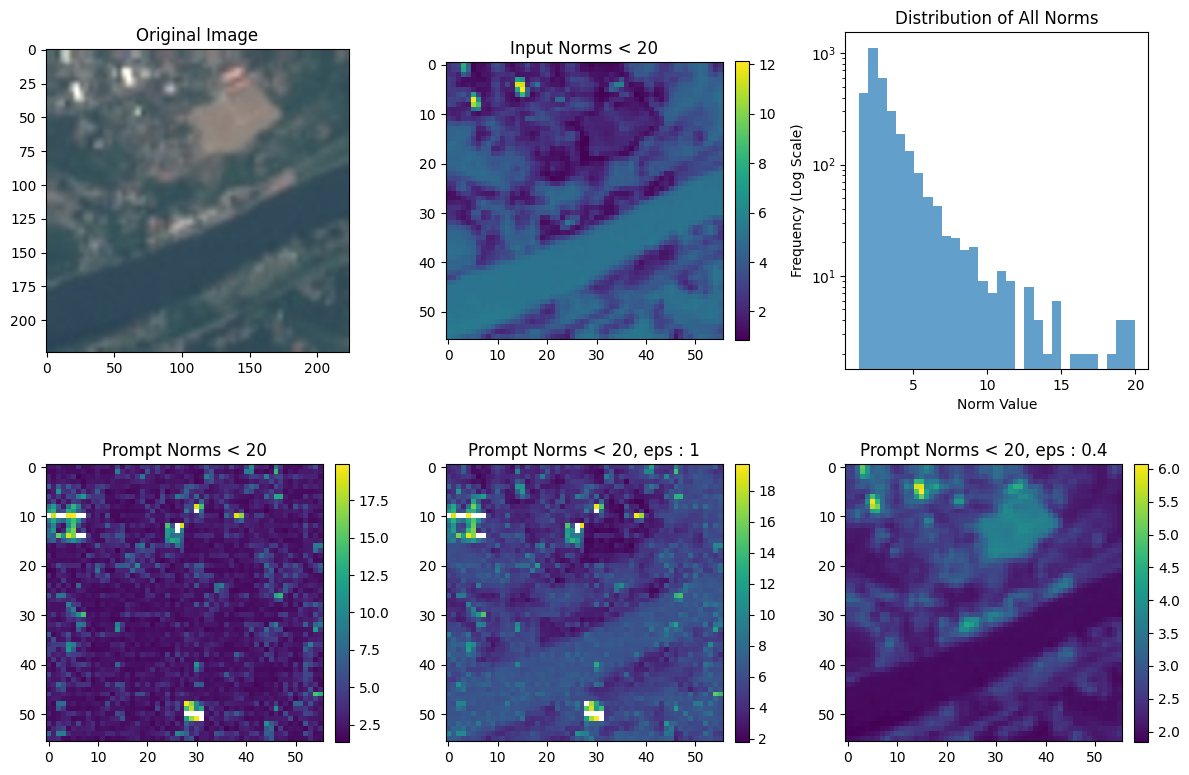

In [35]:
# Create image tensor (assuming the image size is [1, 3, 224, 224])
eps = [1, 0.4]
input_tensor_1 = img.cpu() + prompt.cpu() * eps[0]
input_tensor_2 = img.cpu() + prompt.cpu() * eps[1]
patch_size = 4
threshold = 20

# Process both input and prompt tensors
norms_img, img_indices = extract_patches_and_calculate_norms(img, patch_size, threshold)
norms_prompt, prompt_indices = extract_patches_and_calculate_norms(prompt.cpu(), patch_size, threshold)
norms_input_1, input_1_indices = extract_patches_and_calculate_norms(input_tensor_1, patch_size, threshold)
norms_input_2, input_2_indices = extract_patches_and_calculate_norms(resized_img_tensor, patch_size, threshold)

# Setup plot
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Original image
axs[0, 0].imshow(ori_img.resize((224, 224)))
axs[0, 0].set_title('Original Image')

# Plot norms under threshold for input and prompt
plot_norms_under_threshold(axs[0, 1], norms_img, img_indices, f'Input Norms < {threshold}')
plot_norms_under_threshold(axs[1, 0], norms_prompt, prompt_indices, f'Prompt Norms < {threshold}')
plot_norms_under_threshold(axs[1, 1], norms_input_1, input_1_indices, f'Prompt Norms < {threshold}, eps : {eps[0]}')
plot_norms_under_threshold(axs[1, 2], norms_input_2, input_2_indices, f'Prompt Norms < {threshold}, eps : {eps[1]}')

# Distribution of all norms (Histogram)
axs[0, 2].hist(norms_prompt.numpy(), bins=30, alpha=0.7, log=True)
axs[0, 2].set_xlabel('Norm Value')
axs[0, 2].set_ylabel('Frequency (Log Scale)')
axs[0, 2].set_title('Distribution of All Norms')

plt.tight_layout()
# path = f'check_prompt/{eps}_{patch_size}_{check_under}'
# os.makedirs(path,exist_ok=True)
# plt.savefig(f'{path}/{os.path.basename(i)}')
plt.show()


In [24]:
(prompt.cpu() * eps.cpu()).shape

AttributeError: 'list' object has no attribute 'cpu'

In [21]:
img.shape

torch.Size([1, 3, 224, 224])

In [38]:
MODEL.dec

DecoderManual(
  (body): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2), groups=32)
    (1): ConvTranspose2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): GELU(approximate='none')
    (4): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2), groups=64)
    (5): ConvTranspose2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): GELU(approximate='none')
    (8): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2), groups=32)
    (9): ConvTranspose2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2), groups=32)
    (13): ConvTranspose2d(32, 16, k

In [52]:
z_patch.shape

torch.Size([1, 197, 768])

In [48]:
input_tensor_out = img.cpu() + prompt.cpu() 
image_size = 224
patch_size = 16
patch_number = 14

after_decoder = MODEL.dec(z)
z_patch = MODEL.enc_pt(img.cuda().type(dtype), output_hidden_states=True)[-1][:,1:,:]
z_patch = MODEL.eps_conv(z_patch.unsqueeze(0).transpose(1, 2))
eps = torch.ones((z.shape[0], 1, image_size, image_size)).cpu()
for y in range(0, image_size, patch_size):
    for x in range(0, image_size, patch_size):
        eps[:, :, y:y + patch_size, x:x + patch_size] \
            *= z_patch[:, :, int(y / patch_size) * 14 + int(x / patch_size)].unsqueeze(2).unsqueeze(3).cpu()

AttributeError: 'Coordinator' object has no attribute 'eps_conv'

In [39]:
# Create image tensor (assuming the image size is [1, 3, 224, 224])
MODEL = trainer.model.coordinator
patch_sizes = 1
threshold = 20

prompt =after_decoder.cpu() * eps
# Process both input and prompt tensors
norms_img, img_indices = extract_patches_and_calculate_norms(eps_3, patch_sizes, threshold)
norms_prompt, prompt_indices = extract_patches_and_calculate_norms(prompt.cpu(), patch_sizes, threshold)
norms_input_1, input_1_indices = extract_patches_and_calculate_norms(after_decoder.cpu(), patch_sizes, threshold)
norms_input_2, input_2_indices = extract_patches_and_calculate_norms(img+prompt, patch_sizes, threshold)

# Setup plot
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Original image
axs[0, 0].imshow(ori_img.resize((224, 224)))
axs[0, 0].set_title('Original Image')

# Plot norms under threshold for input and prompt
plot_norms_under_threshold(axs[0, 1], norms_img, img_indices, f'Input Norms < {threshold}', patch_sizes)
plot_norms_under_threshold(axs[1, 0], norms_prompt, prompt_indices, f'Prompt Norms < {threshold}', patch_sizes)
plot_norms_under_threshold(axs[1, 1], norms_input_1, input_1_indices, f'after_decoder < {threshold}', patch_sizes)
plot_norms_under_threshold(axs[1, 2], norms_input_2, input_2_indices, f'img + prompt < {threshold}', patch_sizes)

axs[0, 2].hist(norms_prompt.numpy(), bins=30, alpha=0.7, log=True)
axs[0, 2].set_xlabel('Norm Value')
axs[0, 2].set_ylabel('Frequency (Log Scale)')
axs[0, 2].set_title('Distribution of All Norms')

plt.tight_layout()
# path = f'check_prompt/{eps}_{patch_size}_{check_under}'
# os.makedirs(path,exist_ok=True)
# plt.savefig(f'{path}/{os.path.basename(i)}')
plt.show()


TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
len(batch['impath'])

In [5]:
# len(trainer.cfg.INPUT.TRANSFORMS)# + ('color_jittering',)
# list = random_translation, center_crop, random_crop, randomgrayscale, colorjitter, randaugment2, randaugment_fixmatch,randaugment, cifar10_policy
# imagenet_policy, gaussian_blur, cutout, gaussian_noise
# base is 'random_resized_crop', 'random_flip', 
AVAI_CHOICES = ["random_flip", "random_resized_crop", "normalize", "instance_norm", "random_crop", "random_translation", "center_crop",
    "cutout", "imagenet_policy", "cifar10_policy", "svhn_policy", "randaugment", "randaugment_fixmatch", "randaugment2", "gaussian_noise",
    "colorjitter", "randomgrayscale", "gaussian_blur",]
new_test_type = ["base"]

cfg.merge_from_list(['DATALOADER.TEST.SAMPLER', 'RandomSampler'])
if new_test_type is None:
    pass
elif new_test_type[0] == 'base':
    cfg.merge_from_list(['INPUT.TRANSFORMS', ('normalize', 'new_test_type')])
else:
    cfg.merge_from_list(['INPUT.TRANSFORMS', ('normalize', *new_test_type, 'new_test_type')])

# Creating the tuple with the desired format
trainer = build_trainer(cfg)
trainer.load_model(trainer.output_dir, epoch=5000)
dtype = trainer.model.dtype

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing PromptViTForImageClassification: ['decoder.decoder_layers.5.attention.attention.value.bias', 'decoder.decoder_layers.3.layernorm_before.weight', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.2.attention.attention.query.bias', 'decoder.decoder_layers.1.attention.attention.value.weight', 'decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.6.intermediate.dense.bias', 'decoder.decoder_layers.0.attention.output.dense.bias', 'decoder.decoder_layers.5.layernorm_before.bias', 'decoder.decoder_layers.1.attention.output.dense.weight', 'decoder.decoder_layers.1.output.dense.bias', 'decoder.decoder_layers.4.intermediate.dense.weight', 'decoder.decod

In [ ]:
def clip_clipping(x):
    #! -inf ~ inf -> CLIP's input RGB range
    if len(x.shape) == 3:
        out = torch.cat([torch.clip(x[0,:,:], min=-1.79226253, max=1.93033625).unsqueeze(0),
                     torch.clip(x[1,:,:], min=-1.75209713, max=2.07488384).unsqueeze(0),
                     torch.clip(x[2,:,:], min=-1.48021977, max=2.14589699).unsqueeze(0)], dim=0)
    else:
        out = torch.cat([torch.clip(x[:,0,:,:], min=-1.79226253, max=1.93033625).unsqueeze(1),
                        torch.clip(x[:,1,:,:], min=-1.75209713, max=2.07488384).unsqueeze(1),
                        torch.clip(x[:,2,:,:], min=-1.48021977, max=2.14589699).unsqueeze(1)], dim=1)
    return out
trainer.set_model_mode("eval")
trainer.evaluator.reset()
data_loader =trainer.test_loader

from tqdm import tqdm
whi = 1
for batch_idx, batch in enumerate(data_loader):
    if batch_idx == whi :
        input, label = trainer.parse_batch_test(batch)
        prompt, z = trainer.model.coordinator(input.cuda().type(dtype))
        prompt = clip_clipping(prompt)
        paths = batch['impath']
    elif batch_idx > whi :
        break

import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Generate a dummy tensor representing a batch of 16 images, each with 3 color channels and 224x224 pixels
# In a real scenario, this tensor would be your input images


# Flatten the images to shape [32, 150528]
flattened_images = prompt.cpu().view(32, -1)
flattened_images[1] = flattened_images[1]
# Compute the cosine similarity
cos_sim_matrix = torch.nn.functional.cosine_similarity(flattened_images[:, None], flattened_images, dim=-1)

# 유클리드 거리 계산 함수
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2, dim=-1))

# 맨해튼 거리 계산 함수
def manhattan_distance(x, y):
    return torch.sum(torch.abs(x - y), dim=-1)

euclidean_dist_matrix = torch.zeros(flattened_images.size(0), flattened_images.size(0))
manhattan_dist_matrix = torch.zeros(flattened_images.size(0), flattened_images.size(0))

for i in range(flattened_images.size(0)):
    for j in range(flattened_images.size(0)):
        euclidean_dist_matrix[i, j] = euclidean_distance(flattened_images[i], flattened_images[j])
        manhattan_dist_matrix[i, j] = manhattan_distance(flattened_images[i], flattened_images[j])

# 시각화
fig, axes = plt.subplots(3, 1, figsize=(10, 24))

# 코사인 유사도 매트릭스
sns.heatmap(cos_sim_matrix.numpy(), ax=axes[0], annot=False, cmap='coolwarm')#, vmin=0.97)
axes[0].set_title("Cosine Similarity Matrix")
axes[0].set_xlabel("Image Index")
axes[0].set_ylabel("Image Index")

# 유클리드 거리 매트릭스
sns.heatmap(euclidean_dist_matrix.numpy(), ax=axes[1], annot=False, cmap='coolwarm')
axes[1].set_title("Euclidean Distance Matrix")
axes[1].set_xlabel("Image Index")
axes[1].set_ylabel("Image Index")

# 맨해튼 거리 매트릭스
sns.heatmap(manhattan_dist_matrix.numpy(), ax=axes[2], annot=False, cmap='coolwarm')
axes[2].set_title("Manhattan Distance Matrix")
axes[2].set_xlabel("Image Index")
axes[2].set_ylabel("Image Index")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cos_sim_matrix is your cosine similarity matrix

# Modify Step 1 & 2: Extract only the upper triangular part of the matrix, excluding the diagonal
# This removes the need to set diagonal elements to nan and then filter them out
mask = np.triu_indices_from(cos_sim_matrix, k=1)
cos_sim_values = cos_sim_matrix[mask]

# Step 3 remains the same: Plot the distribution of cosine similarity values
plt.figure(figsize=(10, 6))
sns.histplot(cos_sim_values, bins=30, kde=0)
plt.title('Distribution of Cosine Similarities (Excluding Self-Comparison)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


 59%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 151/254 [03:30<02:23,  1.40s/it]


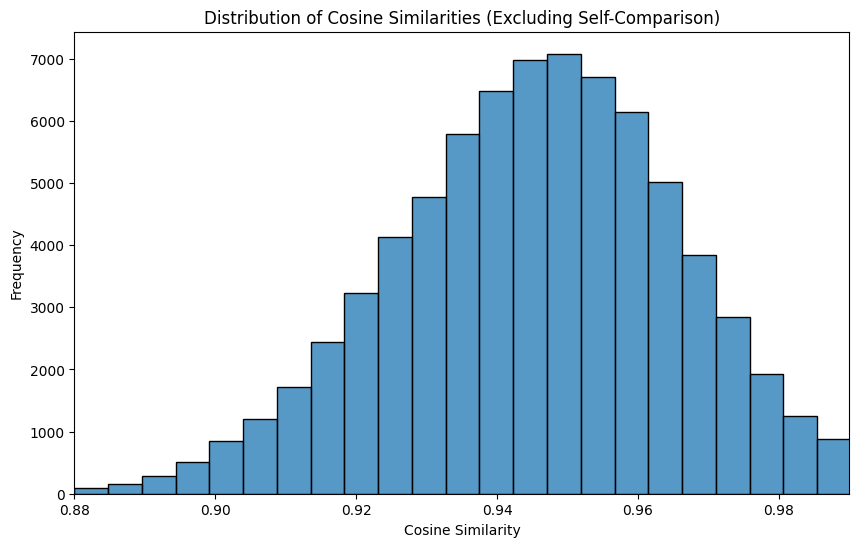

In [7]:
import numpy as np
def clip_clipping(x):
    #! -inf ~ inf -> CLIP's input RGB range
    if len(x.shape) == 3:
        out = torch.cat([torch.clip(x[0,:,:], min=-1.79226253, max=1.93033625).unsqueeze(0),
                     torch.clip(x[1,:,:], min=-1.75209713, max=2.07488384).unsqueeze(0),
                     torch.clip(x[2,:,:], min=-1.48021977, max=2.14589699).unsqueeze(0)], dim=0)
    else:
        out = torch.cat([torch.clip(x[:,0,:,:], min=-1.79226253, max=1.93033625).unsqueeze(1),
                        torch.clip(x[:,1,:,:], min=-1.75209713, max=2.07488384).unsqueeze(1),
                        torch.clip(x[:,2,:,:], min=-1.48021977, max=2.14589699).unsqueeze(1)], dim=1)
    return out
trainer.set_model_mode("eval")
trainer.evaluator.reset()
data_loader =trainer.test_loader
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
whi = 1
for batch_idx, batch in enumerate(tqdm(data_loader)):
    input, label = trainer.parse_batch_test(batch)
    prompt, z = trainer.model.coordinator(input.cuda().type(dtype))
    prompt = clip_clipping(prompt)
    # Flatten the images to shape [32, 150528]
    flattened_images = prompt.cpu().view(32, -1)
    flattened_images[1] = flattened_images[1]
    # Compute the cosine similarity
    cos_sim_matrix = torch.nn.functional.cosine_similarity(flattened_images[:, None], flattened_images, dim=-1)
    mask = np.triu_indices_from(cos_sim_matrix, k=1)
    if not batch_idx:
        cos_sim_values = cos_sim_matrix[mask]
    else:
        cos_sim_values = torch.cat((cos_sim_values, cos_sim_matrix[mask]), dim=0)
    if batch_idx>150:
        break

# Step 3 remains the same: Plot the distribution of cosine similarity values
plt.figure(figsize=(10, 6))
sns.histplot(cos_sim_values, bins=30, kde=0)
plt.title('Distribution of Cosine Similarities (Excluding Self-Comparison)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xlim(0.88, 0.99)
plt.show()


In [27]:
# Create image tensor (assuming the image size is [1, 3, 224, 224])
MODEL = trainer.model.coordinator
patch_sizes = 4
threshold = 20

prompt =aaaa.cpu() * eps
# Process both input and prompt tensors
norms_img, img_indices = extract_patches_and_calculate_norms(img, patch_sizes, threshold)
norms_prompt, prompt_indices = extract_patches_and_calculate_norms(prompt.cpu(), patch_sizes, threshold)
norms_input_1, input_1_indices = extract_patches_and_calculate_norms(img+prompt, patch_sizes, threshold)
norms_input_2, input_2_indices = extract_patches_and_calculate_norms(aaaa.cpu(), patch_sizes, threshold)

# Setup plot
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Original image
axs[0, 0].imshow(ori_img.resize((224, 224)))
axs[0, 0].set_title('Original Image')

# Plot norms under threshold for input and prompt
plot_norms_under_threshold(axs[0, 1], norms_img, img_indices, f'Input Norms < {threshold}',patch_sizes)
plot_norms_under_threshold(axs[1, 0], norms_prompt, prompt_indices, f'Prompt Norms < {threshold}',patch_sizes)
#plot_norms_under_threshold(axs[1, 1], norms_input_1, input_1_indices, f'Prompt Norms < {threshold}',patch_sizes)
# plot_norms_under_threshold(axs[1, 2], norms_input_2, input_2_indices, f'Prompt Norms < {threshold}',patch_sizes)

axs[1,1].imshow((img+prompt).squeeze().permute(1, 2, 0).numpy().clip(0, 1), cmap='gray')
eps_array = eps.squeeze().numpy()
axs[1,2].imshow(eps_array, cmap='gray')
# Distribution of all norms (Histogram)
axs[0, 2].hist(norms_prompt.numpy(), bins=30, alpha=0.7, log=True)
axs[0, 2].set_xlabel('Norm Value')
axs[0, 2].set_ylabel('Frequency (Log Scale)')
axs[0, 2].set_title('Distribution of All Norms')

plt.tight_layout()
# path = f'check_prompt/{eps}_{patch_size}_{check_under}'
# os.makedirs(path,exist_ok=True)
# plt.savefig(f'{path}/{os.path.basename(i)}')
plt.show()


NameError: name 'aaaa' is not defined

In [28]:
# Create image tensor (assuming the image size is [1, 3, 224, 224])
MODEL = trainer.model.coordinator
patch_size = 4
threshold = 20
input_tensor_out = img.cpu() + prompt.cpu() 

wrap = MODEL.dec(z)
z_p = MODEL.enc_pt(img.cuda().type(dtype), output_hidden_states=True)[-1][-1][0,1:,:]
patch_reshape = z_p.reshape(14, 14, 768)
patch_reshape = patch_reshape.permute(2, 0, 1)
eps = MODEL.eps_conv(patch_reshape.unsqueeze(0))# if not self.smoothing else self.eps_conv(self.LayerNorm(patch_reshape))
upscaled_eps = eps.repeat_interleave(16, dim=2).repeat_interleave(16, dim=3)
upscaled_eps = upscaled_eps.expand(-1, 3, -1, -1)

# Process both input and prompt tensors
norms_img, img_indices = extract_patches_and_calculate_norms(img, patch_size, threshold)
norms_prompt, prompt_indices = extract_patches_and_calculate_norms(prompt.cpu(), patch_size, threshold)
norms_wrap, wrap_indices = extract_patches_and_calculate_norms(wrap, 4, threshold)
norms_eps, eps_indices = extract_patches_and_calculate_norms(upscaled_eps.cpu(), 1)


# Setup plot
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Original image
axs[0, 0].imshow(ori_img.resize((224, 224)))
axs[0, 0].set_title('Original Image')


# Plot norms under threshold for input and prompt
plot_norms_under_threshold(axs[0, 1], norms_img, img_indices, f'Input Norms < {threshold}', patch_size)
plot_norms_under_threshold(axs[1, 0], norms_prompt, prompt_indices, f'Prompt Norms < {threshold}', patch_size)
plot_norms_under_threshold(axs[1, 1], norms_wrap.cpu(), wrap_indices, f'wrap Nrom',4)
plot_norms_under_threshold(axs[1, 2], norms_eps, eps_indices, f'eps Norms', 1)

# Distribution of all norms (Histogram)
axs[0, 2].hist(norms_prompt.numpy(), bins=30, alpha=0.7, log=True)
axs[0, 2].set_xlabel('Norm Value')
axs[0, 2].set_ylabel('Frequency (Log Scale)')
axs[0, 2].set_title('Distribution of All Norms')

plt.tight_layout()
# path = f'check_prompt/{eps}_{patch_size}_{check_under}'
# os.makedirs(path,exist_ok=True)
# plt.savefig(f'{path}/{os.path.basename(i)}')
plt.show()


IndexError: too many indices for tensor of dimension 1

In [ ]:
from glob import glob
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

patch_size = 4
threshold = 20
path = f'check_prompt/{patch_size}_{threshold}_new'
os.makedirs(path,exist_ok=True)
MODEL = trainer.model.coordinator

with torch.no_grad():
    trainer.set_model_mode("eval")
    trainer.evaluator.reset()
    for i in glob('datasets/eurosat/2750/Highway/*.jpg'):
        ori_img = Image.open(i).convert("RGB")
        img = tensor_tr(ori_img)
        img = img.unsqueeze(0)
        prompt, _ = trainer.model.coordinator(img.cuda().type(dtype))
        
        # Create wrap and eps
        wrap = MODEL.dec(z)
        z_p = MODEL.enc_pt(img.cuda().type(dtype), output_hidden_states=True)[-1][-1][0,1:,:]
        patch_reshape = z_p.reshape(14, 14, 768)
        patch_reshape = patch_reshape.permute(2, 0, 1)
        eps = MODEL.eps_conv(patch_reshape.unsqueeze(0))# if not self.smoothing else self.eps_conv(self.LayerNorm(patch_reshape))
        upscaled_eps = eps.repeat_interleave(16, dim=2).repeat_interleave(16, dim=3)
        upscaled_eps = upscaled_eps.expand(-1, 3, -1, -1)
        
        
        input_tensor_out = img.cpu() + prompt.cpu()
        # Process both input and prompt tensors
        norms_eps, eps_indices = extract_patches_and_calculate_norms(upscaled_eps.cpu(), 1)
        norms_img, img_indices = extract_patches_and_calculate_norms(img, patch_size, threshold)
        norms_prompt, prompt_indices, prompt_norm = extract_patches_and_calculate_norms(prompt.cpu(), patch_size, threshold, check=True)
        norms_input, input_indices = extract_patches_and_calculate_norms(input_tensor_out, patch_size, threshold)
        
        
        # Setup plot
        fig, axs = plt.subplots(2, 3, figsize=(12, 8))
        
        # Original image
        axs[0, 0].imshow(ori_img.resize((224, 224)))
        axs[0, 0].set_title('Original Image')
        
        # Plot norms under threshold for input and prompt
        plot_norms_under_threshold(axs[0, 1], norms_img, img_indices, f'Input Norms < {threshold}')
        plot_norms_under_threshold(axs[1, 0], norms_eps, eps_indices, f'Eps Norms < {threshold}', 1)
        plot_norms_under_threshold(axs[1, 1], norms_prompt, prompt_indices, f'Prompt Norms < {threshold}')
        plot_norms_under_threshold(axs[1, 2], norms_input, input_indices, f'Input Norms < {threshold}')
        
        # Distribution of all norms (Histogram)
        axs[0, 2].hist(prompt_norm.numpy(), bins=30, alpha=0.7, log=True)
        axs[0, 2].set_xlabel('Norm Value')
        axs[0, 2].set_ylabel('Frequency (Log Scale)')
        axs[0, 2].set_title('Distribution of All Norms')
        
        plt.tight_layout()
        plt.savefig(f'{path}/{os.path.basename(i)}')
        plt.show()


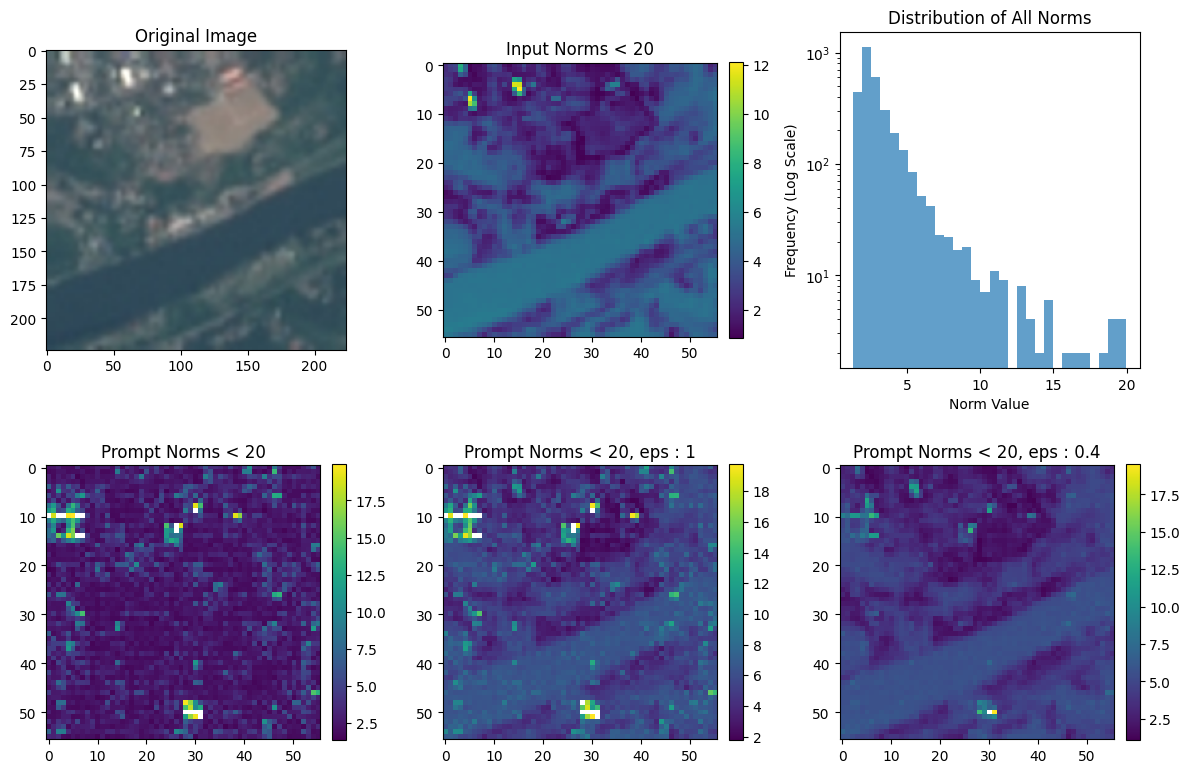

In [17]:
# Create image tensor (assuming the image size is [1, 3, 224, 224])
eps = [1, 0.4]
input_tensor_1 = img.cpu() + prompt.cpu() * eps[0]
input_tensor_2 = img.cpu() + prompt.cpu() * eps[1]
patch_size = 4
threshold = 20

# Process both input and prompt tensors
norms_img, img_indices = extract_patches_and_calculate_norms(img, patch_size, threshold)
norms_prompt, prompt_indices = extract_patches_and_calculate_norms(prompt.cpu(), patch_size, threshold)
norms_input_1, input_1_indices = extract_patches_and_calculate_norms(input_tensor_1, patch_size, threshold)
norms_input_2, input_2_indices = extract_patches_and_calculate_norms(input_tensor_2, patch_size, threshold)

# Setup plot
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Original image
axs[0, 0].imshow(ori_img.resize((224, 224)))
axs[0, 0].set_title('Original Image')

# Plot norms under threshold for input and prompt
plot_norms_under_threshold(axs[0, 1], norms_img, img_indices, f'Input Norms < {threshold}')
plot_norms_under_threshold(axs[1, 0], norms_prompt, prompt_indices, f'Prompt Norms < {threshold}')
plot_norms_under_threshold(axs[1, 1], norms_input_1, input_1_indices, f'Prompt Norms < {threshold}, eps : {eps[0]}')
plot_norms_under_threshold(axs[1, 2], norms_input_2, input_2_indices, f'Prompt Norms < {threshold}, eps : {eps[1]}')

# Distribution of all norms (Histogram)
axs[0, 2].hist(norms_prompt.numpy(), bins=30, alpha=0.7, log=True)
axs[0, 2].set_xlabel('Norm Value')
axs[0, 2].set_ylabel('Frequency (Log Scale)')
axs[0, 2].set_title('Distribution of All Norms')

plt.tight_layout()
# path = f'check_prompt/{eps}_{patch_size}_{check_under}'
# os.makedirs(path,exist_ok=True)
# plt.savefig(f'{path}/{os.path.basename(i)}')
plt.show()
